# CROC-CARIB12-Default
## Regional CESM-MOM6 for Caribbean with Default CrocoDash Grids and Inputs

This notebook is working off of a basic version of CARIB12 (Seijo-Ellis et al. 2024). The goal of this first test is to run the same domain over a short time period from January 1st, 2000 to January 5th, 2000 and compare with CARIB12. We are using the same grids and resolution, but the topography, CESM version, and tidal data are the different. This also uses the built in CrocoDash feature to generate a custom script to fetch glorys data using the copernicusmarine CLI; this should be the same as Gio's data (need to verify).

## Generate Regional MOM6 Domain

### Horizontal Grid

In [1]:
from CrocoDash.grid import Grid

grid = Grid(
    resolution=1/12, # 1/12 deg resolution (hopefully fraction doesn't cause an issue)
    xstart=261.5, # 261.5° E or 98.5° W 
    lenx=63, # 35.5° W
    ystart=-6, # 6° S
    leny=38, # 32° N
    name='CrocCaribDefaultCoarse'
)

grid.write_supergrid(path="/glade/work/ajanney/CaribCrocoDash/CrocCarib_Misc/grids/CrocCarib12_hgrid.nc",author='ajanney')

### Bathymetry

In [6]:
from CrocoDash.topo import Topo

'''
topo = Topo(
    grid = grid,
    min_depth=10, # 10 meters defined by Gio in /glade/work/ajanney/CaribCrocoDash/INPUT_Gio/INPUT/topo.carib_012v1.SRTM15_V2.4.SmL2.0_C2.0_edited_v3.nc
)
'''
## After already interpolating, more efficient to just load it in
topo = Topo.from_topo_file(
    grid = grid,
    topo_file_path='/glade/work/ajanney/CrocoDash_Input/CrocCaribDefault_Coarse/ocnice/ocean_topog_CrocCaribDefault_729cf6.nc',
    min_depth=10 # meters
    )

In [3]:
## After already interpolating, more efficient to just load it in
'''
bathymetry_path = '/glade/work/ajanney/CrocoDashData/inputs/bathymetry/GEBCO_2024_coarse_x4.nc'


topo.interpolate_from_file(
    file_path=bathymetry_path,
    longitude_coordinate_name='lon',
    latitude_coordinate_name='lat',
    vertical_coordinate_name='elevation'
)
'''

"\nbathymetry_path = '/glade/work/ajanney/CrocoDashData/inputs/bathymetry/GEBCO_2024_coarse_x4.nc'\n\n\ntopo.interpolate_from_file(\n    file_path=bathymetry_path,\n    longitude_coordinate_name='lon',\n    latitude_coordinate_name='lat',\n    vertical_coordinate_name='elevation'\n)\n"

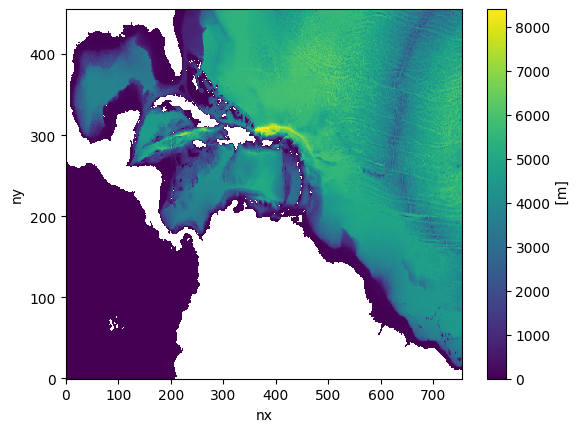

In [7]:
topo.depth.plot()

In [8]:
# Erase Pacific & Canada Bays
%matplotlib ipympl

from CrocoDash.topo_editor import TopoEditor
topo.depth["units"] = "m"
TopoEditor(topo)

TopoEditor(children=(VBox(children=(HTML(value='<h2>Topo Editor</h2>'), HTML(value='<hr><h3>Display</h3>'), To…

<Figure size 640x480 with 0 Axes>

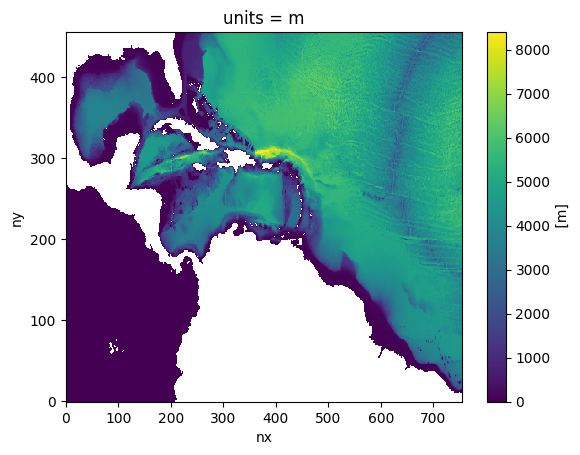

In [6]:
## Check bathymetry again after edits
import matplotlib.pyplot as plt

%matplotlib inline
plt.clf()
plt.figure()
topo.depth.plot()

## Vertical Grid

In [11]:
from CrocoDash.vgrid import VGrid

vgrid  = VGrid.hyperbolic(
    nk = 65,
    depth = topo.max_depth,
    ratio=99.48 # from Gio's paper 248.7/2.5=99.48
)

In [12]:
import numpy as np
print(vgrid.dz)
plt.plot(vgrid.dz,-np.cumsum(vgrid.dz),'o-')

[  3.04371687   3.14589928   3.27013902   3.42116813   3.60471985
   3.82773372   4.09859952   4.4274458    4.82647885   5.31037754
   5.89674812   6.60664078   7.46512501   8.50191432   9.75201959
  11.25639499  13.06251859  15.22482047  17.80483499  20.87091074
  24.49726749  28.76215259  33.74483481  39.52120593  46.15786615
  53.70477681  62.18688471  71.59553516  81.88091921  92.94710902
 104.65125205 116.80807814 129.2        141.59192186 153.74874795
 165.45289098 176.51908079 186.80446484 196.21311529 204.69522319
 212.24213385 218.87879407 224.65516519 229.63784741 233.90273251
 237.52908926 240.59516501 243.17517953 245.33748141 247.14360501
 248.64798041 249.89808568 250.93487499 251.79335922 252.50325188
 253.08962246 253.57352115 253.9725542  254.30140048 254.57226628
 254.79528015 254.97883187 255.12986098 255.25410072 255.35628313]


NameError: name 'plt' is not defined

## Creating the CESM Case

In [13]:
from pathlib import Path

# CESM case (experiment) name
casename = "CrocCaribDefault_Coarse"

# CESM source root (Update this path accordingly!!!)
cesmroot = '/glade/work/ajanney/CESM-versions/CROC_CESM' # Path.home() / "cesm3_0_beta04"
# I grabbed this version from Alper

# Place where all your input files go 
inputdir = Path("/glade/work/ajanney/CrocoDash_Input",casename) # Path.home() / "croc_input" / casename
    
# CESM case directory
caseroot = Path("/glade/work/ajanney/CESM/cases",casename) # Path.home() / "croc_cases" / casename

In [14]:
from CrocoDash.case import Case

case = Case(
    cesmroot = cesmroot,
    caseroot = caseroot,
    inputdir = inputdir,
    ocn_grid = grid,
    ocn_vgrid = vgrid,
    ocn_topo = topo,
    project = 'P93300012', # also can be unspecified if set by user config e.g. export PBS_ACCOUNT=P93300012
    override = True,
)

INFO:  csp_solver:CspSolver initialized.


Creating case...

• Updating ccs_config/modelgrid_aliases_nuopc.xml file to include the new resolution "CrocCaribDefault_Coarse" consisting of the following component grids.
 atm grid: "TL319", lnd grid: "TL319", ocn grid: "CrocCaribDefaultCoarse".

• Updating ccs_config/component_grids_nuopc.xml file to include newly generated ocean grid "CrocCaribDefaultCoarse" with the following properties:
 nx: 756, ny: 456. ocean mesh: /glade/work/ajanney/CrocoDash_Input/CrocCaribDefault_Coarse/ocnice/ESMF_mesh_CrocCaribDefaultCoarse_98d529.nc.

Running the create_newcase tool with the following command:

/glade/work/ajanney/CESM-versions/CROC_CESM/cime/scripts/create_newcase --compset 1850_DATM%JRA_SLND_SICE_MOM6_SROF_SGLC_SWAV --res CrocCaribDefault_Coarse --case /glade/work/ajanney/CESM/cases/CrocCaribDefault_Coarse --machine derecho --run-unsupported --project P93300012 

The create_newcase command was successful.

Navigating to the case directory:

cd /glade/work/ajanney/CESM/cases/CrocCaribD

INFO:	stage:SUCCESS: All stages are complete.


Case created successfully at /glade/work/ajanney/CESM/cases/CrocCaribDefault_Coarse.

To further customize, build, and run the case, navigate to the case directory in your terminal. To create another case, restart the notebook.



## Ocean Forcing Data from Glorys

In [11]:
start_date_iter = "2000-01-01 00:00:00"
end_date_iter = "2020-01-05 00:00:00"

case.configure_forcings(
    date_range = [start_date_iter, end_date_iter],
    tidal_constituents = ['M2', 'S2', 'N2', 'K2', 'K1', 'O1', 'P1', 'Q1', 'MM', 'MF'],
    tpxo_elevation_filepath = "/glade/work/ajanney/CrocoDashData/inputs/tidal_data/h_tpxo9.v1.nc", 
    # original: "/glade/u/home/manishrv/manish_scratch_symlink/inputs_rm6/tidal_data/h_tpxo9.v1.nc",
    tpxo_velocity_filepath = "/glade/work/ajanney/CrocoDashData/inputs/tidal_data/u_tpxo9.v1.nc" 
    # original: "/glade/u/home/manishrv/manish_scratch_symlink/inputs_rm6/tidal_data/u_tpxo9.v1.nc"
)

INFO:CrocoDash.data_access.glorys:This data access method retuns a script at path /glade/derecho/scratch/ajanney/tmp/tmpsojy2n85/get_glorys_data.sh to run to get access data 
INFO:CrocoDash.data_access.glorys:This data access method retuns a script at path /glade/work/ajanney/CrocoDash_Input/CrocCaribDefault_Coarse/glorys/get_glorys_data.sh to run to get access data 
INFO:CrocoDash.data_access.glorys:This data access method retuns a script at path /glade/work/ajanney/CrocoDash_Input/CrocCaribDefault_Coarse/glorys/get_glorys_data.sh to run to get access data 
INFO:CrocoDash.data_access.glorys:This data access method retuns a script at path /glade/work/ajanney/CrocoDash_Input/CrocCaribDefault_Coarse/glorys/get_glorys_data.sh to run to get access data 
INFO:CrocoDash.data_access.glorys:This data access method retuns a script at path /glade/work/ajanney/CrocoDash_Input/CrocCaribDefault_Coarse/glorys/get_glorys_data.sh to run to get access data 
INFO:CrocoDash.data_access.glorys:This data a

This domain is too big, so we use Manish's latest cool tool the Data Access module instead, this will generate a script for retrieving the data either from the RDA or through a PBS script (I think, it may always be through the RDA)

In [ ]:
from CrocoDash.data_access import glorys as gl
from CrocoDash.data_access import driver as dv
import xarray as xr

raw_data_sub_folder = '/glade/work/ajanney/CrocoDash_Input/CrocCaribDefault_Coarse/glorys_raw'

hgrid = xr.open_dataset(
"/glade/work/ajanney/CrocoDash_Input/CrocCaribDefault_Coarse/ocnice/ocean_hgrid_CrocCaribDefault_7728f2.nc"
)
bounds = dv.get_rectangular_segment_info(hgrid)
key = "ic" # or east, north, west, south, ic
gl.get_glorys_data_from_rda([start_date_iter,end_date_iter], bounds[key]["lat_min"], bounds[key]["lat_max"], bounds[key]["lon_min"], bounds[key]["lon_max"], output_dir = raw_data_sub_folder, output_file = key+"_unprocessed.nc")

INFO:CrocoDash.data_access.glorys:Downloading Glorys data from RDA to /glade/work/ajanney/CrocoDash_Input/CrocCaribDefault_Coarse/glorys_raw/ic_unprocessed.nc


In [12]:
case.process_forcings()

INFO:regional_mom6.regridding:Getting t points..
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Creating Regridder


Setting up Initial Conditions
Regridding Velocities... 

INFO:regional_mom6.rotation:Getting rotation angle
INFO:regional_mom6.rotation:Calculating grid rotation angle
INFO:regional_mom6.regridding:Getting u points..
INFO:regional_mom6.regridding:Getting v points..


Done.
Regridding Tracers... Done.
Regridding Free surface... Done.
Saving outputs... done setting up initial condition.
Processing south boundary velocity & tracers...

INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.rotation:Getting rotation angle
INFO:regional_mom6.rotation:Calculating grid rotation angle
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Adding time dimension
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in salt_segment_001
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to salt_segment_001
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in temp_segment_001
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to temp_segment_001
INFO:regional_mom6.regriddin

Done.
Processing north boundary velocity & tracers...

INFO:regional_mom6.rotation:Getting rotation angle
INFO:regional_mom6.rotation:Calculating grid rotation angle
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Adding time dimension
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in salt_segment_002
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to salt_segment_002
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in temp_segment_002
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to temp_segment_002
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in u_segment_002
INFO:regional_mom6.regridding:Replacing old depth coordinates with incr

Done.
Processing west boundary velocity & tracers...

INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.rotation:Getting rotation angle
INFO:regional_mom6.rotation:Calculating grid rotation angle
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Adding time dimension
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in salt_segment_003
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to salt_segment_003
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in temp_segment_003
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to temp_segment_003
INFO:regional_mom6.regriddin

Done.
Processing east boundary velocity & tracers...

INFO:regional_mom6.rotation:Getting rotation angle
INFO:regional_mom6.rotation:Calculating grid rotation angle
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Adding time dimension
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in salt_segment_004
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to salt_segment_004
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in temp_segment_004
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to temp_segment_004
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in u_segment_004
INFO:regional_mom6.regridding:Replacing old depth coordinates with incr

Done.


INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Creating Regridder


Processing south boundary...

INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Adding time dimension
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Adding perpendicular dimension to zamp_segment_001
INFO:regional_mom6.regridding:Adding perpendicular dimension to zphase_segment_001
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.rotation:Getting rotat

Done
Processing north boundary...

INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Adding time dimension
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Adding perpendicular dimension to zamp_segment_002
INFO:regional_mom6.regridding:Adding perpendicular dimension to zphase_segment_002
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.rotation:Getting rotat

Done
Processing west boundary...

INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Adding time dimension
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Adding perpendicular dimension to zamp_segment_003
INFO:regional_mom6.regridding:Adding perpendicular dimension to zphase_segment_003
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.rotation:Getting rotat

Done
Processing east boundary...

INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Adding time dimension
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Adding perpendicular dimension to zamp_segment_004
INFO:regional_mom6.regridding:Adding perpendicular dimension to zphase_segment_004
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.rotation:Getting rotat

Done
Adding parameter changes to user_nl_mom:

  ! Initial conditions
  INIT_LAYERS_FROM_Z_FILE = True
  TEMP_SALT_Z_INIT_FILE = init_tracers.nc
  Z_INIT_FILE_PTEMP_VAR = temp
  Z_INIT_ALE_REMAPPING = True
  TEMP_SALT_INIT_VERTICAL_REMAP_ONLY = True
  DEPRESS_INITIAL_SURFACE = True
  SURFACE_HEIGHT_IC_FILE = init_eta.nc
  SURFACE_HEIGHT_IC_VAR = eta_t
  VELOCITY_CONFIG = file
  VELOCITY_FILE = init_vel.nc

  ! Tides
  TIDES = True
  TIDE_M2 = True
  CD_TIDES = 0.0018
  TIDE_USE_EQ_PHASE = True
  TIDE_REF_DATE = 2000, 1, 1
  OBC_TIDE_ADD_EQ_PHASE = True
  OBC_TIDE_N_CONSTITUENTS = 10
  OBC_TIDE_CONSTITUENTS = "M2, S2, N2, K2, K1, O1, P1, Q1, MM, MF"
  OBC_TIDE_REF_DATE = 2000, 1, 1

  ! Open boundary conditions
  OBC_NUMBER_OF_SEGMENTS = 4
  OBC_FREESLIP_VORTICITY = False
  OBC_FREESLIP_STRAIN = False
  OBC_COMPUTED_VORTICITY = True
  OBC_COMPUTED_STRAIN = True
  OBC_ZERO_BIHARMONIC = True
  OBC_TRACER_RESERVOIR_LENGTH_SCALE_OUT = 3.0E+04
  OBC_TRACER_RESERVOIR_LENGTH_SCALE_IN = 3000.0
